TODO:  
[X] Generate features with ECAPA  
[] Test VAD      

# Baseline2 - Preprocessing (Wav2Vec Features) - PT-BR-SER (Coraa V6)

This is an example of pre-processing audio segments to extract features through the pre-trained Wav2Vec model (small). We use the Fairseq toolkit. No fine-tuning was performed and we only used the audio embedding extracted from the pre-trained model.

We use raw audio, i.e., no pre-processing or cleaning has been done beforehand. Participants can pre-process the audio to improve the quality of extracted features. We also recommend using the latest pre-trained models, fine-tuning and data augmentation.

# Download Dataset

* https://drive.google.com/drive/folders/12Nuv8J7pBHJuNU3nH2c7F8VwCDEE6GDt

In [15]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import glob
from tqdm import tqdm

In [16]:
paths = glob.glob('../../data/train/*.wav')

In [17]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
def predict_ecapa(filepath):
    signal, fs = torchaudio.load(filepath)
    return classifier.encode_batch(signal)

In [18]:
from os import listdir
from os.path import isfile, join
import pandas as pd

train_data_dir = 'train'

train_audio_files = paths

L = []
for f in train_audio_files:
  v = f.replace('.wav','').split('_')
  L.append([f,v[len(v)-1]])

df_data = pd.DataFrame(L)
df_data.columns = ['sound_filepath','label']

In [20]:
embeddings = [predict_ecapa(i).flatten().numpy() for i in tqdm(paths)]

100%|██████████| 625/625 [06:33<00:00,  1.59it/s]


In [21]:
df_embeddings = pd.DataFrame(embeddings)

In [22]:
df_embeddings['sound_filepath'] = paths

In [23]:
df_ecapatdnn = pd.merge(df_embeddings,df_data, on ='sound_filepath')

<AxesSubplot:>

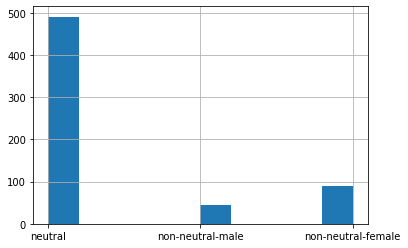

In [24]:
df_ecapatdnn.label.hist()

# ECAPA-TDNN Features

Related methods.

> Desplanques, Brecht, Jenthe Thienpondt, and Kris Demuynck. "Ecapa-tdnn: Emphasized channel attention, propagation and aggregation in tdnn based speaker verification." arXiv preprint arXiv:2005.07143 (2020).


In [25]:
df_ecapatdnn.to_csv('ecapatdnn_features.csv',index=False)

# TODO apply VAD

In [59]:
! pip install -U speechbrain

     |████████████████████████████████| 393 kB 2.9 MB/s eta 0:00:01
  Attempting uninstall: speechbrain
    Found existing installation: speechbrain 0.5.7
    Uninstalling speechbrain-0.5.7:
      Successfully uninstalled speechbrain-0.5.7


In [1]:
import speechbrain
speechbrain.__version__

'0.5.10'

In [3]:
from speechbrain.pretrained import VAD

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")


In [13]:
# 1- Let's compute frame-level posteriors first
audio_file = paths[0]
prob_chunks = VAD.get_speech_prob_file(audio_file)
# 2- Let's apply a threshold on top of the posteriors
prob_th = VAD.apply_threshold(prob_chunks).float()

In [ ]:



# 3- Let's now derive the candidate speech segments
boundaries = VAD.get_boundaries(prob_th)

# 4- Apply energy VAD within each candidate speech segment (optional)

boundaries = VAD.energy_VAD(audio_file,boundaries)

# 5- Merge segments that are too close
boundaries = VAD.merge_close_segments(boundaries, close_th=0.250)

# 6- Remove segments that are too short
boundaries = VAD.remove_short_segments(boundaries, len_th=0.250)

# 7- Double-check speech segments (optional).
boundaries = VAD.double_check_speech_segments(boundaries, audio_file,  speech_th=0.5)